In [3]:
import torch
import torchvision.models as models
import warnings
import os
import random
import cv2
import faiss
import torch.nn as nn
import matplotlib.pyplot as plt
import albumentations as A
import torch.optim as optim
import numpy as np
import tqdm.auto as tqdm
import torch.nn.functional as F

from torchvision.models import ResNet50_Weights, MobileNet_V3_Large_Weights
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image

In [4]:
warnings.filterwarnings("ignore")
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Dataset & Dataloader
`ImageNet Mean: (0.485, 0.456, 0.406)`  
`ImageNet Std: (0.229, 0.224, 0.225)`

In [5]:
def get_picture_statistic(image_path):
    widths = []
    heights = []
    
    for img in os.listdir(image_path):
        im = cv2.imread(os.path.join(image_path, img), cv2.COLOR_BGR2RGB)
        widths.append(im.shape[1])
        heights.append(im.shape[0])

    avg_width = round(sum(widths)/len(widths),2)
    avg_height = round(sum(heights)/len(heights),2)
    max_width = max(widths)
    max_height = max(heights)

    return avg_width, avg_height, max_width, max_height

In [6]:
avg_width, avg_height, max_width, max_height= get_picture_statistic(image_path="/opt/ml/total/association/woo/training") ########### CHANGE!
print(f"Average Width: {avg_width}")
print(f"Average Height: {avg_height}")
print(f"Max Width: {max_width}")
print(f"Max Height: {max_height}")

Average Width: 103.48
Average Height: 250.59
Max Width: 413
Max Height: 619


In [7]:
class ETHZ_GALLERY(Dataset):
    def __init__(self, gallery_path, transform):
        super().__init__()
        self.gallery_path = gallery_path
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.gallery_path))

    def __getitem__(self, item):
        gallery_image_name = os.listdir(self.gallery_path)[item]
        gallery_label = gallery_image_name
        gallery_image = cv2.imread(os.path.join(self.gallery_path, gallery_image_name), cv2.COLOR_BGR2RGB)

        if self.transform:
            transformed = self.transform(image=gallery_image)
            gallery_image = transformed['image']

        gallery_image = gallery_image.astype(np.float32)
        gallery_image = torch.from_numpy(gallery_image)
        gallery_image = torch.permute(gallery_image, (2,0,1))

        return gallery_image, gallery_label
    
class ETHZ_QUERY(Dataset):
    def __init__(self, query_path, transform):
        super().__init__()
        self.query_path = query_path
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.query_path))

    def __getitem__(self, item):
        query_image_name = os.listdir(self.query_path)[item]
        query_label = query_image_name
        query_image = cv2.imread(os.path.join(self.query_path, query_image_name), cv2.COLOR_BGR2RGB)

        if self.transform:
            transformed = self.transform(image=query_image)
            query_image = transformed['image']

        query_image = query_image.astype(np.float32)
        query_image = torch.from_numpy(query_image)
        query_image = torch.permute(query_image, (2,0,1))

        return query_image, query_label

In [8]:
class ETHZ(Dataset):
    def __init__(self, path):
        super().__init__()
        self.path = path
        self.people_list = sorted(os.listdir(path))
        
    def __len__(self):
        return len(self.people_list)

    def __getitem__(self, item):
        # anchor
        anchor_name = self.people_list[item]
        anchor_id = int(anchor_name[:5])
        anchor = cv2.imread(os.path.join(self.path, anchor_name), cv2.COLOR_BGR2RGB)
        
        # positive
        positive_name = self.people_list[item-1]
        positive_id = int(positive_name[:5])
        try:
            while positive_id == 0:
                positive_name = self.people_list[item-5]
        except:
                positive_name = anchor_name
        positive = cv2.imread(os.path.join(self.path, positive_name), cv2.COLOR_BGR2RGB)

        # negative
        negative_name = random.choice(self.people_list) 
        negative_id = int(negative_name[:5])
        while negative_id == anchor_id:
            negative_name = random.choice(self.people_list) 
            negative_id = int(negative_name[:5])
        negative = cv2.imread(os.path.join(self.path, negative_name), cv2.COLOR_BGR2RGB)

        set_images = [anchor, positive, negative]

        if (anchor.shape[:2] != positive.shape[:2]) or (anchor.shape[:2] != negative.shape[:2]) or (positive.shape[:2] != negative.shape[:2]):
            tf = A.Compose([A.Resize(224,224),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

            for idx, i in enumerate(set_images):
                transformed = tf(image=i)
                set_images[idx] = transformed['image']
                set_images[idx] = set_images[idx].astype(np.float32)
                set_images[idx] = torch.from_numpy(set_images[idx])
                set_images[idx] = torch.permute(set_images[idx], (2,0,1))

        return set_images[0], set_images[1], set_images[2], anchor_id

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Anchor Label: 11


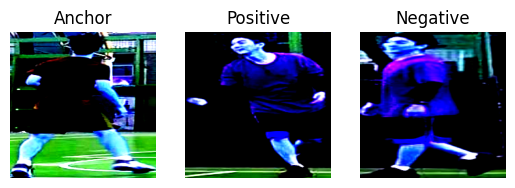

In [9]:
path = "./training" ########### CHANGE!
dataset = ETHZ(path=path)
anchor, positive, negative, gt = next(iter(dataset))
print("Anchor Label:", gt)

fig, ax = plt.subplots(1,3)
ax[0].imshow(torch.permute(anchor, (1,2,0)))
ax[1].imshow(torch.permute(positive, (1,2,0)))
ax[2].imshow(torch.permute(negative, (1,2,0)))

for idx, name in enumerate(["Anchor", "Positive", "Negative"]):
    ax[idx].set_title(name)
    ax[idx].axis('off')

In [10]:
train_set = DataLoader(dataset=dataset, batch_size=64, shuffle=True, pin_memory=True, drop_last=True, num_workers=8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


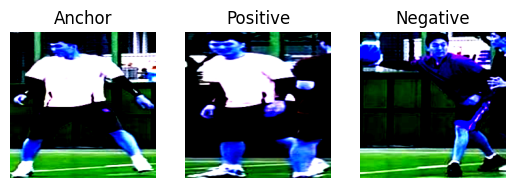

In [11]:
a, p, n, _ = next(iter(train_set))

fig, ax = plt.subplots(1,3)
ax[0].imshow(torch.permute(a[0], (1,2,0)))
ax[1].imshow(torch.permute(p[0], (1,2,0)))
ax[2].imshow(torch.permute(n[0], (1,2,0)))

for idx, name in enumerate(["Anchor", "Positive", "Negative"]):
    ax[idx].set_title(name)
    ax[idx].axis('off')

## Loss Function

In [12]:
class QuadrupletLoss(torch.nn.Module):
    """
    Quadruplet loss function.
    Builds on the Triplet Loss and takes 4 data input: one anchor, one positive and two negative examples. The negative examples needs not to be matching the anchor, the positive and each other.
    """
    def __init__(self, margin1=2.0, margin2=1.0):
        super(QuadrupletLoss, self).__init__()
        self.margin1 = margin1
        self.margin2 = margin2

    def forward(self, anchor, positive, negative1, negative2):

        squarred_distance_pos = (anchor - positive).pow(2).sum(1)
        squarred_distance_neg = (anchor - negative1).pow(2).sum(1)
        squarred_distance_neg_b = (negative1 - negative2).pow(2).sum(1)

        quadruplet_loss = F.relu(self.margin1 + squarred_distance_pos - squarred_distance_neg) + F.relu(self.margin2 + squarred_distance_pos - squarred_distance_neg_b)

        return quadruplet_loss.mean()

In [13]:
# my version of triplet loss
def triplet_loss(anchor, positive, negative, margin=1.0):
    positive_distance = ((anchor-positive)**2).sum(1).sqrt() # we need to create tensor to be "[value]" rather than just "value"
    negative_distance = ((anchor-negative)**2).sum(1).sqrt()
    loss = torch.relu(margin + positive_distance - negative_distance)
    return loss.mean()

## Model
* ResNet50 (25.56M - 75.3% Top-1 Acc ImageNet Classification)
* MobileNetV3 (5.48M - 75.2% Top-1 Acc ImageNet Classification)

In [17]:
embedding_dim = 1000

In [18]:
class ResNet_Triplet(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.resnet50.fc = nn.Linear(in_features=2048, out_features=embedding_dim, bias=True)
     
    def forward(self, x):
        embedding_feature = self.resnet50(x)
        return embedding_feature
    
#a = torch.rand(1, 3, 512, 512)
#model_resnet50 = ResNet_Triplet(embedding_dim=embedding_dim)
#model_resnet50(a).shape

In [19]:
class MobileNetV3_Triplet(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.mobilenetv3 = models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights)
        self.mobilenetv3.classifier[3] = nn.Linear(in_features=1280, out_features=embedding_dim, bias=True)
     
    def forward(self, x):
        embedding_feature = self.mobilenetv3(x)
        return embedding_feature
    
#a = torch.rand(1, 3, 512, 512)
#model_mobilenetv3 = MobileNetV3_Triplet(embedding_dim=embedding_dim)
#model_mobilenetv3(a).shape

In [20]:
# Model Complexity & Parameters
# with torch.cuda.device(0):
#     macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True, print_per_layer_stat=True, verbose=True)
#     print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
#     print('{:<30}  {:<8}'.format('Number of parameters: ', params))

## Train

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MobileNetV3_Triplet(embedding_dim=embedding_dim)
epochs = 50
learning_rate = 0.0001
criterion = nn.TripletMarginLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

weight_path = f"/opt/ml/total/weight/association/mobilenet_{embedding_dim}embed" # DON'T FORGET TO CHANGE MODEL's NAME ########### CHANGE!

if os.path.isdir(weight_path) == False:
    os.mkdir(weight_path) # DON'T FORGET TO CHANGE MODEL's NAME ########### CHANGE!

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /opt/ml/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 91.7MB/s]


In [22]:
def validation(model, query_dataset, gallery_dataset, gallery_path, embedding_dim, topk): 
    faiss_index = faiss.IndexFlatL2(embedding_dim)
    model = model.to(device)
    model.eval()

    gallery_list = []
    query_list = []
    matched_list = []
    with torch.no_grad():
        for gallery, labels in gallery_dataset:
            gallery = gallery.to(device)

            outputs = model(gallery).cpu().numpy()
            
            for out, label in zip(outputs, labels):
                faiss_index.add(out.reshape(1,-1)) 
                gallery_list.append(label) 
                
    with torch.no_grad():
        for query, label in query_dataset:
            for i in label:
                query_list.append(i)
            query = query.to(device)

            outputs = model(query).cpu().numpy()
            _, I = faiss_index.search(outputs, topk)
            for x in I:
                tmp = [gallery_list[x[i]] for i in range(topk)]
                matched_list.append(tmp)

    def calculate_map(query_list, matched_list, gallery_path):   
        total_query_gt = 0
        precision = 0
        count = 0
        AP = 0
        mAP = []
        for query_name, matched_name in zip(query_list, matched_list):
            # calculate total query gt
            for x in os.listdir(gallery_path):
                if query_name[:3] == x[:3]:
                    total_query_gt += 1

            # calculate ap
            tmp_total_query_gt = total_query_gt
            for _, i in enumerate(matched_name,start=1):
                count += 1
                if tmp_total_query_gt == 0:
                    break
                elif query_name[:3] == i[:3]:
                    precision += 1
                    tmp_total_query_gt -= 1
                else:
                    continue
                AP += (precision/count)
            mAP.append(AP/total_query_gt)

            # reset
            AP = 0
            total_query_gt = 0
            precision = 0
            count = 0
            
        return sum(mAP)/len(mAP)
                    
    return calculate_map(query_list, matched_list, gallery_path)

In [23]:
def train(model, epochs, criterion, optimizer, train_loader, query_dataset, gallery_dataset, gallery_path, embedding_dim, topk):
    print(f"Start Training...")
    print()
    best_mAP = 0
    changes = 0
    model = model.to(device)
    for epoch in range(epochs):
        model.train()
        for step, (anchor, positive, negative, _) in enumerate(train_loader):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            
            optimizer.zero_grad(set_to_none=True)
            anchor_features = model(anchor) 
            positive_features = model(positive)
            negative_features = model(negative)

            loss = criterion(anchor_features, positive_features, negative_features)
            loss.backward()
            optimizer.step()

            if (step+1) % 25 == 0:
                print(f"Epoch:[{epoch}/{epochs}] | Step:[{step+1}/{len(train_loader)}] | Loss:{loss.item():.4f}")

        
        mAP = validation(model=model, query_dataset=query_dataset, gallery_dataset=gallery_dataset, gallery_path=gallery_path, embedding_dim=embedding_dim, topk=topk)
        if mAP >= best_mAP:
            print(f"Best mAP is achieved!!")
            print("Saving Best and Latest Model...")
            torch.save(model.state_dict(), os.path.join(weight_path, f"best{epoch}.pth"))
            changes = mAP - best_mAP
            best_mAP = mAP

        torch.save(model.state_dict(), os.path.join(weight_path, f"latest.pth"))
        print("All Model Checkpoints Saved!")
        print("----------------------------")
        print(f"Best mAP: {best_mAP:.4f}")
        if mAP >= best_mAP:
            print(f"Current mAP: {mAP:.4f} (+{(changes):.4f})")
        elif mAP < best_mAP:
            print(f"Current mAP: {mAP:.4f} (-{(best_mAP-mAP):.4f})")
        print()

In [24]:
# Woo
gallery_path = "./gallery" ########### CHANGE!
query_path = "./query" ########### CHANGE!
total_gallery_images = len(os.listdir(gallery_path))

tf = A.Compose([A.Resize(224,224),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

query_dataset = ETHZ_QUERY(query_path, tf)
gallery_dataset = ETHZ_GALLERY(gallery_path, tf)

query_dataset = DataLoader(query_dataset, batch_size=256, shuffle=False, num_workers=8, pin_memory=False, drop_last=False)
gallery_dataset = DataLoader(gallery_dataset, batch_size=256, shuffle=False, num_workers=8, pin_memory=False, drop_last=False)

In [ ]:
train(model=model, epochs=epochs, criterion=criterion, optimizer=optimizer, train_loader=train_set, 
      query_dataset=query_dataset, gallery_dataset=gallery_dataset, gallery_path=gallery_path, embedding_dim=embedding_dim, topk=total_gallery_images)

Start Training...

Epoch:[0/50] | Step:[25/27] | Loss:0.5474
Best mAP is achieved!!
Saving Best and Latest Model...
All Model Checkpoints Saved!
----------------------------
Best mAP: 0.8174
Current mAP: 0.8174 (+0.8174)

Epoch:[1/50] | Step:[25/27] | Loss:0.1818
Best mAP is achieved!!
Saving Best and Latest Model...
All Model Checkpoints Saved!
----------------------------
Best mAP: 0.9080
Current mAP: 0.9080 (+0.0905)

Epoch:[2/50] | Step:[25/27] | Loss:0.1483
Best mAP is achieved!!
Saving Best and Latest Model...
All Model Checkpoints Saved!
----------------------------
Best mAP: 0.9244
Current mAP: 0.9244 (+0.0164)

Epoch:[3/50] | Step:[25/27] | Loss:0.1920
Best mAP is achieved!!
Saving Best and Latest Model...
All Model Checkpoints Saved!
----------------------------
Best mAP: 0.9352
Current mAP: 0.9352 (+0.0108)

Epoch:[4/50] | Step:[25/27] | Loss:0.3037
Best mAP is achieved!!
Saving Best and Latest Model...
All Model Checkpoints Saved!
----------------------------
Best mAP: 0.94

## Inference
---

In [21]:
# Basketball
# gallery_path = "./datasets/data_reid/reid_test/gallery"
# query_path = "./datasets/data_reid/reid_test/query"

# Woo
gallery_path = "./datasets/woo/gallery" ########### CHANGE!
query_path = "./datasets/woo/query" ########### CHANGE!
 
tf = A.Compose([A.Resize(224,224),
                 A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

query_dataset = ETHZ_QUERY(query_path, tf)
gallery_dataset= ETHZ_GALLERY(gallery_path, tf)

query_dataset = DataLoader(query_dataset, batch_size=256, shuffle=False, num_workers=8, pin_memory=False, drop_last=False)
gallery_dataset = DataLoader(gallery_dataset, batch_size=256, shuffle=False, num_workers=8, pin_memory=False, drop_last=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


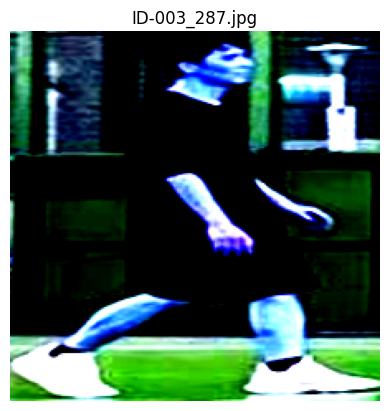

In [22]:
image, label = next(iter(gallery_dataset))
fig, ax = plt.subplots(1,1)
ax.imshow(torch.permute(image[0], (1,2,0)))
ax.set_title(f"ID-{label[0]}")
ax.set_axis_off()

In [23]:
# with batch
def inference(model, query_dataset, gallery_dataset, embedding_dim, topk): 
    assert topk >= 1

    faiss_index = faiss.IndexFlatL2(embedding_dim)
    model = model.to(device)
    model.eval()

    gallery_list = []
    query_list = []
    matched_list = []
    with torch.no_grad():
        for gallery, labels in gallery_dataset:
            gallery = gallery.to(device)

            outputs = model(gallery).cpu().numpy() # (8, 436)
            
            for out, label in zip(outputs, labels):
                faiss_index.add(out.reshape(1,-1)) # (1, 436)
                gallery_list.append(label) 
                
    with torch.no_grad():
        for query, label in query_dataset:
            for i in label:
                query_list.append(i)
            query = query.to(device)

            outputs = model(query).cpu().numpy()
            
            _, I = faiss_index.search(outputs, topk)
            for x in I:
                tmp = [gallery_list[x[i]] for i in range(topk)]
                matched_list.append(tmp)
                    
    return query_list, matched_list

In [24]:
inference_dim = 1000
model = MobileNetV3_Triplet(embedding_dim=inference_dim)
model.load_state_dict(torch.load(os.path.join(f"/opt/ml/input/jaekyu/model/mobilenetv3_woo_{inference_dim}embed", "best.pth"))) ########### CHANGE!
query_list, matched_list = inference(model=model, query_dataset=query_dataset, gallery_dataset=gallery_dataset, embedding_dim=inference_dim, topk=total_gallery_images)

In [25]:
def show_inference(topk, query_list, matched_list, stop=0):
    if topk == 1:
        _, ax = plt.subplots(1,1+topk)
        for step, (query_name, matched_name) in enumerate(zip(query_list, matched_list)): 
            matched = cv2.imread(os.path.join(gallery_path, matched_name))
            query = cv2.imread(os.path.join(query_path, query_name))

            matched = cv2.cvtColor(matched, cv2.COLOR_BGR2RGB)
            query = cv2.cvtColor(query, cv2.COLOR_BGR2RGB)

            ax[0].imshow(query)
            ax[1].imshow(matched)

            ax[0].set_title(f"Query: {query_name[:6]}")
            ax[1].set_title(f"Matched: {matched_name[:6]}")

            ax[0].axis('off')
            ax[1].axis('off')
            
            if step == stop:
                break
    else:
        _, ax = plt.subplots(1,1+topk, figsize=(10,5))
        for step, (query_name, matched_name) in enumerate(zip(query_list, matched_list)):
            # query
            query = cv2.imread(os.path.join(query_path, query_name))
            query = cv2.cvtColor(query, cv2.COLOR_BGR2RGB)
            ax[0].imshow(query)
            ax[0].set_title(f"Query: {query_name[:6]}")
            ax[0].axis('off')

            # matched
            for i in range(topk):
                ax[i+1].imshow(cv2.cvtColor(cv2.imread(os.path.join(gallery_path, matched_name[i])), cv2.COLOR_BGR2RGB))
                ax[i+1].set_title(f"Matched: {matched_name[i][:6]}")
                ax[i+1].axis('off')

            if step == stop:
                break

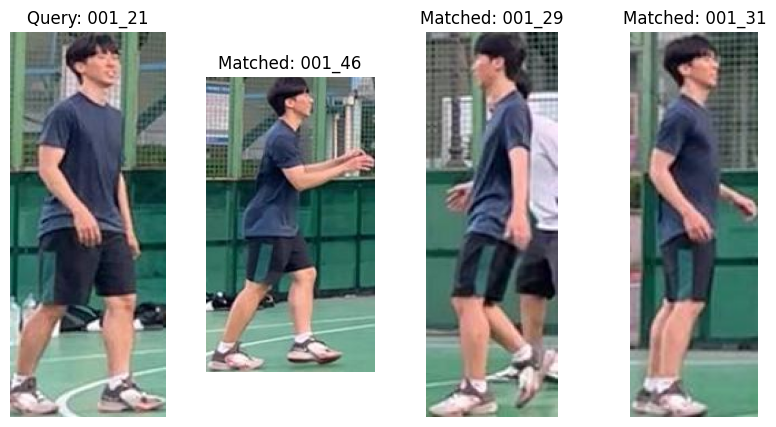

In [26]:
show_inference(topk=3, query_list=query_list, matched_list=matched_list, stop=0) # 24, 34, 35, 37, 41, 50

In [27]:
matched_list

[['001_460.jpg',
  '001_299.jpg',
  '001_317.jpg',
  '001_371.jpg',
  '001_92.jpg',
  '001_112.jpg',
  '001_324.jpg',
  '001_356.jpg',
  '001_71.jpg',
  '001_209.jpg',
  '001_69.jpg',
  '001_213.jpg',
  '001_212.jpg',
  '001_115.jpg',
  '001_372.jpg',
  '001_110.jpg',
  '001_363.jpg',
  '001_150.jpg',
  '001_298.jpg',
  '001_408.jpg',
  '001_220.jpg',
  '001_89.jpg',
  '001_361.jpg',
  '001_355.jpg',
  '001_68.jpg',
  '001_74.jpg',
  '001_364.jpg',
  '001_319.jpg',
  '001_405.jpg',
  '001_205.jpg',
  '001_210.jpg',
  '001_387.jpg',
  '001_451.jpg',
  '001_455.jpg',
  '001_334.jpg',
  '001_255.jpg',
  '001_320.jpg',
  '001_56.jpg',
  '001_124.jpg',
  '001_91.jpg',
  '001_127.jpg',
  '001_67.jpg',
  '001_221.jpg',
  '001_186.jpg',
  '001_459.jpg',
  '001_58.jpg',
  '001_65.jpg',
  '001_114.jpg',
  '001_57.jpg',
  '001_153.jpg',
  '001_156.jpg',
  '001_207.jpg',
  '001_97.jpg',
  '001_252.jpg',
  '001_157.jpg',
  '001_125.jpg',
  '001_128.jpg',
  '001_374.jpg',
  '001_434.jpg',
  '001_106

## Hard Voting
---

In [ ]:
# Hard Voting
from collections import Counter

def hard_voting(matched_list):
    final = []
    tmp = []
    for list in matched_list:
        for j in list:
            tmp.append(int(j[:3]))
        count = Counter(tmp)
        final.append(count.most_common(1)[0][0])
        tmp = []

    return final

hard_voting(matched_list=matched_list)

## Evaluation Metrics
* CMC
* mAP
---

### CMC

In [28]:
# to calculate 20 topk, please inference topk with 20 beforehand
def calculate_cmc(query_list, matched_list, topk):
    count = 0
    total = 0
    rank = []

    for x in range(1, topk+1):
        for (query_name, matched_name) in zip(query_list, matched_list):
            for gallery in matched_name[:x]:
                if query_name[:3] == gallery[:3]:
                    count += 1
                    break
            total += 1
        rank.append((count/total)*100)
        count, total = 0, 0
    return rank

rank = calculate_cmc(query_list=query_list, matched_list=matched_list, topk=20)
for i in rank:
    print(i)

99.0
99.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0


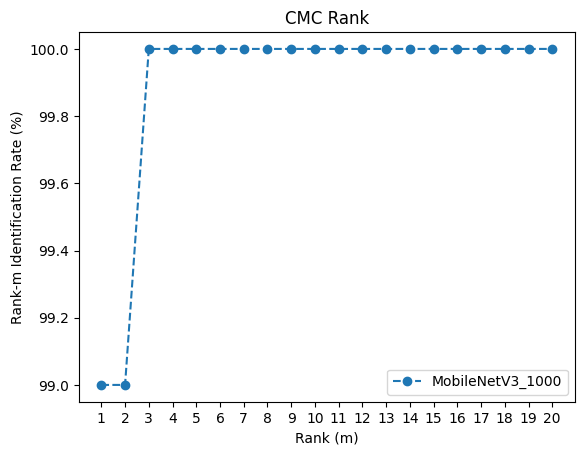

In [29]:
x_label = [i for i in range(1, 20+1)]
y_label = rank

plt.plot(x_label, y_label, label=f"MobileNetV3_{embedding_dim}", linestyle="--", marker='o')
plt.title("CMC Rank")
plt.xlabel("Rank (m)")
plt.ylabel("Rank-m Identification Rate (%)")
plt.xticks(range(1,21))
plt.legend()
plt.show()

### mAP

In [30]:
def calculate_map(query_list, matched_list, gallery_path):
    print(f'Number of Queries: {len(query_list)}')
    
    total_query_gt = 0
    precision = 0
    count = 0
    AP = 0
    mAP = []
    for query_name, matched_name in zip(query_list, matched_list):
        # calculate total query gt
        for x in os.listdir(gallery_path):
            if query_name[:3] == x[:3]:
                total_query_gt += 1

        # calculate ap
        tmp_total_query_gt = total_query_gt
        for _, i in enumerate(matched_name,start=1):
            count += 1
            if tmp_total_query_gt == 0:
                break
            elif query_name[:3] == i[:3]:
                precision += 1
                tmp_total_query_gt -= 1
            else:
                continue
            AP += (precision/count)
        mAP.append(AP/total_query_gt)

        # reset
        AP = 0
        total_query_gt = 0
        precision = 0
        count = 0
        
    print(f"mAP: {sum(mAP)/len(mAP)}")

calculate_map(query_list=query_list, matched_list=matched_list, gallery_path=gallery_path)

Number of Queries: 200
mAP: 0.9757103087995354
